<a href="https://colab.research.google.com/github/Murcha1990/ML_AI24/blob/main/Hometasks/Pro/AI_HW5_boosting_pro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


## **Домашняя работа 5: Бустинг и кластеризация**

### **Постановка задачи:**

В этой работы ваша задача подразделена на части:

*   В первой части вам предстоит реалищовать класс бустинга и сравнить его со встроенными классами популярных библиотек;
*   Во второй части вам предстоит применить алгоритмы кластеризации в задаче  разделения изображения на семантические компоненты;

### **Оценивание:**

- Как всегда оцениваются как код, так и ответы на вопросы. Если нет одного и/или другого, то часть баллов за соответствующее задание без колебаний снимается.
- Брать код из открытых источников позволительно. Следование культуре цитирования **обязательно.**

### **Баллы:**

Суммарно за задание можно получить 10 основных и 1 бонусный балл.

Оценка за ДЗ = min{ваш балл, 10}

**Мягкий дедлайн: 16 февраля 23:59**

**Интересной вам работы!**

## **Часть 1: построение класса алгоритма бустинга**

**Количество баллов:** 7

Начнём с нужных библиотек и загрузки данных. Работать будем с датасетом из Kaggle и с синтетическим датасетом.

Данные c Kaggle связаны с телефонной рекламой португальского банковского учреждения. Цель классификации — спрогнозировать, подпишется ли клиент на срочный депозит (переменная y).

Всего в данных 20 признаков, ознакомиться с признаковым описанием можно [здесь](https://www.kaggle.com/code/sachinrajput17/subscription-prediction-for-bank-marketing-data).

Будем действовать из предположений, что датасет достаточно хорош, чтобы мы уже могли построить на нём базовую модель.

In [1]:
import numpy as np
import pandas as pd
import plotly.express as px

from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score, f1_score, log_loss, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
!wget  -O 'bank_data.csv' -q 'https://www.dropbox.com/s/uy27mctxo0gbuof/bank_data.csv?dl=0'

"wget" �� ���� ����७��� ��� ���譥�
��������, �ᯮ��塞�� �ணࠬ��� ��� ������ 䠩���.


In [4]:
df = pd.read_csv('https://www.dropbox.com/s/uy27mctxo0gbuof/bank_data.csv?dl=1')
df.sample(5)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
4839,64,retired,married,university.degree,no,yes,yes,cellular,apr,tue,...,2,999,0,nonexistent,-1.8,93.075,-47.1,1.405,5099.1,-1
840,62,retired,married,professional.course,no,yes,yes,cellular,aug,fri,...,2,999,1,failure,-2.9,92.201,-31.4,0.825,5076.2,1
8075,42,admin.,single,high.school,no,no,no,cellular,sep,wed,...,1,14,1,success,-1.1,94.199,-37.5,0.880,4963.6,1
6104,50,admin.,married,university.degree,no,no,no,cellular,jul,thu,...,1,999,0,nonexistent,-2.9,92.469,-33.6,1.072,5076.2,1
6424,61,retired,married,university.degree,no,no,no,telephone,aug,tue,...,2,3,1,success,-2.9,92.201,-31.4,0.859,5076.2,1


Разделим на train и test (random_state не меняем)

In [5]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

In [6]:
X_train = df_train.drop('y', axis=1)
X_test = df_test.drop('y', axis=1)

y_train = df_train['y']
y_test = df_test['y']

Генерируем синтетические данные (seed не меняем)

In [7]:
np.random.seed(42)

num_obs = 10 ** 5
num_thresholds = 50

X_synthetic = np.random.normal(scale=3, size=[num_obs, 2])
x1_thresholds = np.random.choice(X_synthetic[:, 0], num_thresholds, False)
x2_thresholds = np.random.choice(X_synthetic[:, 1], num_thresholds, False)

gains = np.random.uniform(-0.4086, 0.5, size=[2 * num_thresholds, 1])
x1_thresholds_cond = [X_synthetic[:, 0] >= threshold for threshold in x1_thresholds]
x2_thresholds_cond = [X_synthetic[:, 1] >= threshold for threshold in x2_thresholds]

noise = np.random.uniform(-0.5, 0.5, size=num_obs)

y_synthetic_probits = np.sum(
    gains[:num_thresholds] * x1_thresholds_cond + gains[num_thresholds:] * x2_thresholds_cond, axis=0
) + noise
y_synthetic = np.sign(y_synthetic_probits)

X_train_synthetic, y_train_synthetic = X_synthetic[:int(num_obs * 0.8)], y_synthetic[:int(num_obs * 0.8)]
X_test_synthetic, y_test_synthetic = X_synthetic[int(num_obs * 0.8):], y_synthetic[int(num_obs * 0.8):]

px.histogram(x = y_synthetic_probits, nbins=100)

Некоторый полезный код для визуализации предсказаний (пригодится позже)

In [8]:
import matplotlib.pyplot as plt

def plot_predicts(model, features, targets, x_lim=[-15.0, 15.0], y_lim=[-15.0, 15.0],
                  examples_density=0.1, steps=1000, num_ticks=6, title='', mode='classification'):
    '''
    Функция для визуализации предсказаний модели на двухмерной плоскости
    param model: обученная модель классификации или регрессии для двухмерных объектов
    param features: признаки выборки (a.k.a. X)
    param targets: целевая переменная выборки (a.k.a y)
    param x_lim: пределы для x
    param y_lim: пределы для y
    param examples_density: доля выборки, которая будет нарисована
    param steps: частота разбиения плоскости
    param num_ticks: число подписей на графике
    param title: заголовок графика
    param mode: режим 'classification' - вероятности положительного класса
                режим 'regression' - вещественная целевая переменная
    '''

    mask = np.random.choice([True, False], size=features.shape[0],
                            p=[examples_density, 1.0 - examples_density])
    features_x = (features[mask, 0] - x_lim[0]) / (x_lim[1] - x_lim[0]) * steps
    features_y = (features[mask, 1] - y_lim[0]) / (y_lim[1] - y_lim[0]) * steps

    xs = np.linspace(x_lim[0], x_lim[1], steps)
    ys = np.linspace(y_lim[0], y_lim[1], steps)

    xs, ys = np.meshgrid(xs, ys)
    grid = np.stack([xs.flatten(), ys.flatten()], axis=1)
    if mode == 'classification':
        predicts = model.predict_proba(grid)[:, 1].reshape(steps, steps)
        values = (targets[mask] == 1).astype(np.float16)
    elif mode == 'regression':
        predicts = model.predict(grid).reshape(steps, steps)
        values = targets[mask]
    else:
        raise ValueError('Unknown mode')

    plt.figure(figsize=(10, 10))
    plt.imshow(predicts, origin='lower')
    plt.scatter(features_x, features_y, c=values, edgecolors='white', linewidths=1.5)
    plt.legend()
    plt.colorbar()

    plt.xticks(np.linspace(0, steps, num_ticks), np.linspace(x_lim[0], x_lim[1], num_ticks))
    plt.yticks(np.linspace(0, steps, num_ticks), np.linspace(y_lim[0], y_lim[1], num_ticks))
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(title)
    plt.grid()
    plt.show()

### **Задание 1. (4 балла) Реализуйте бустинг для задачи бинарной классификации**

Реализовывать класс буситнга необходимо согласно его теоретическому описанию. Вы начинаете с параметрами:

- `base_model_class=DecisionTreeRegressor` — базовая модель
- `base_model_params: dict={'max_features': 0.1}` — параметрмы базовой модели, рассчет максимального количества признаков полагаем как: `max(1, int(max_features * n_features_in_))`
- `n_estimators: int=10` — количество моделей
- `learning_rate: float=0.1` — скорость обучения
- `subsample: float=0.3` — доля данных, которая будет использоваться для подбора отдельных алгоритмов.
— `random_seed: int=228` — тут как всегда
– `custom_loss: list or tuple=None` — функция потерь
— `use_best_model: bool=False` — использовать ли при вызове predict и predict_proba лучшее с точки зрения валидационной выборки число деревьев в композиции
— `n_iter_early_stopping: int=None` — ранний критерий остановки

**Примечание:**

Поскольку градиентный бустинг обучается через последовательное создание моделей, может получиться так, что оптимальная с точки зрения генерализации модель будет получена на промежуточной итерации. Обычно для контроля такого поведения в методе `fit` передается также валидационная выборка, по которой можно оценивать общее качество модели в процессе обучения (желательно делать это каждую итерацию, но если ваша имплементация слишком медленная или ваше железо не тянет, можно делать это реже).

**Примечание 2:**

Нет смысла обучать действительно глубокую модель на 1000 деревьев и больше, если оптимальный ансамбль получился, к примеру, на 70 итерации и в течение какого-то количества итераций не улучшился - поэтому мы также задействуем early stopping при отсутствии улучшений в течение некоторого числа итераций.

In [30]:
class Boosting:

    def __init__(
        self,
        base_model_class=DecisionTreeRegressor,
        base_model_params: dict={'max_features': 0.1},
        n_estimators: int=10,
        learning_rate: float=0.1,
        subsample: float=0.3,
        random_seed: int=228,
        custom_loss: list=None,
        use_best_model: bool=False,
        n_iter_early_stopping: int=None
    ):

        # Класс базовой модели
        self.base_model_class = base_model_class
        # Параметры для инициализации базовой модели
        self.base_model_params = base_model_params
        # Число базовых моделей
        self.n_estimators = n_estimators
        # Длина шага (которая в лекциях обозначалась через eta)
        self.learning_rate = learning_rate
        # Доля объектов, на которых обучается каждая базовая модель
        self.subsample = subsample
        # seed для бутстрапа, если хотим воспроизводимость модели
        self.random_seed = random_seed
        # Использовать ли при вызове predict и predict_proba лучшее
        # с точки зрения валидационной выборки число деревьев в композиции
        self.use_best_model = use_best_model
        # число итераций, после которых при отсутствии улучшений на валидационной выборке обучение завершается
        self.n_iter_early_stopping = n_iter_early_stopping

        # Место для нулевой модели
        self.initial_model_pred = None

        # Список для хранения весов при моделях
        self.gammas = []

        # Создаем список базовых моделей
        self.models = []

        # Если используем свою функцию потерь, ее нужно передать как список из loss-a и его производной
        if custom_loss is not None:
            self.loss_fn, self.loss_derivative = custom_loss
        else:
            self.sigmoid = lambda z: 1 / (1 + np.exp(-z))
            self.loss_fn = lambda y, z: -np.log(self.sigmoid(y * z)).mean()
            self.loss_derivative = lambda y, z: -y * self.sigmoid(-y * z)


    def _fit_new_model(self, X: np.ndarray, y: np.ndarray or list, n_model: int):
        """
        Функция для обучения одной базовой модели бустинга
        :param X: матрица признаков
        :param y: вектор целевой переменной
        :param n_model: номер модели, которую хотим обучить
        """
        np.random.seed(self.random_seed)
        sample_indices = np.random.choice(X.shape[0], size=int(self.subsample * X.shape[0]), replace=False)
        X_sample, y_sample = X[sample_indices], y[sample_indices]

        model = self.base_model_class(**self.base_model_params)
        model.fit(X_sample, y_sample)
        return model


    def _fit_initial_model(self, X, y):
        """
        Функция для построения нулевой (простой) модели. Не забудьте взять логарифм, потому что сигмоида применяется
        уже к сумме предсказаний базовых моделей, а не к каждому предсказанию каждой модели по отдельности.
        Подойдёт константная модель, возвращающая самый популярный класс,
        но если хотите, можете сделать что-нибудь посложнее.
        """
        # self.initial_model_pred = np.log(np.mean(y) / (1 - np.mean(y)))
        self.initial_model_pred = np.unique(y)[np.unique(y, return_counts=True)[1].argmax()]

    def _find_optimal_gamma(self, y: np.ndarray or list, old_predictions: np.ndarray,
                            new_predictions: np.ndarray, boundaries: tuple or list=(0.01, 10)):
        """
        Функция для поиска оптимального значения параметра gamma (коэффициент перед новой базовой моделью).
        :param y: вектор целевой переменной
        :param old_predictions: вектор суммы предсказаний предыдущих моделей (до сигмоиды)
        :param new_predictions: вектор суммы предсказаний новой модели (после сигмоиды)
        :param boudnaries: в каком диапазоне искать оптимальное значение ɣ (array-like объект из левой и правой границ)
        """
        # Определеяем начальные лосс и оптимальную гамму
        loss, optimal_gamma = self.loss_fn(y, old_predictions), 0
        # Множество, на котором будем искать оптимальное значение гаммы
        gammas = np.linspace(*boundaries, 10)
        # Простым перебором ищем оптимальное значение
        for gamma in gammas:
            predictions = old_predictions + gamma * new_predictions
            gamma_loss = self.loss_fn(y, predictions)
            if gamma_loss < loss:
                optimal_gamma = gamma
                loss = gamma_loss

        return optimal_gamma


    def fit(self, X, y, eval_set=None):
        """
        Функция для обучения всей модели бустинга
        :param X: матрица признаков
        :param y: вектор целевой переменной
        :eval_set: кортеж (X_val, y_val) для контроля процесса обучения или None, если контроль не используется
        """

        self._fit_initial_model(X, y)
        predictions = np.full_like(y, self.initial_model_pred, dtype=float)
        best_score = -np.inf
        no_improvement_count = 0
        for n_model in range(self.n_estimators):
            residuals = -self.loss_derivative(y, predictions)
            model = self._fit_new_model(X, residuals, n_model)
            new_predictions = model.predict(X)
            gamma = self._find_optimal_gamma(y, predictions, new_predictions)
            self.gammas.append(gamma)
            self.models.append(model)
            predictions += self.learning_rate * gamma * new_predictions

            if eval_set is not None:
                X_val, y_val = eval_set
                val_predictions = self.predict(X_val)
                score = accuracy_score(y_val, val_predictions)
                if score > best_score:
                    best_score = score
                    self.best_iteration = n_model
                    no_improvement_count = 0
                else:
                    no_improvement_count += 1

                if self.n_iter_early_stopping is not None and no_improvement_count >= self.n_iter_early_stopping:
                    break


    def predict(self, X: np.ndarray):
        """
        Функция для предсказания классов обученной моделью бустинга
        :param X: матрица признаков
        """

        predictions = np.full(X.shape[0], self.initial_model_pred, dtype=float)
        for gamma, model in zip(self.gammas, self.models):
            predictions += self.learning_rate * gamma * model.predict(X)

        if self.use_best_model and self.best_iteration is not None:
            predictions = np.full(X.shape[0], self.initial_model_pred, dtype=float)
            for gamma, model in zip(self.gammas[:self.best_iteration + 1], self.models[:self.best_iteration + 1]):
                predictions += self.learning_rate * gamma * model.predict(X)

        return np.where(predictions >= 0, 1, -1)

    def predict_proba(self, X: np.ndarray):
        """
        Функция для предсказания вероятностей классов обученной моделью бустинга
        :param X: матрица признаков
        """
        predictions = np.full(X.shape[0], self.initial_model_pred, dtype=float)
        for gamma, model in zip(self.gammas, self.models):
            predictions += self.learning_rate * gamma * model.predict(X)

        if self.use_best_model and self.best_iteration is not None:
            predictions = np.full(X.shape[0], self.initial_model_pred, dtype=float)
            for gamma, model in zip(self.gammas[:self.best_iteration + 1], self.models[:self.best_iteration + 1]):
                predictions += self.learning_rate * gamma * model.predict(X)

        proba = self.sigmoid(predictions)
        return np.vstack((1 - proba, proba)).T
    
    def score(self, X, y):
        """
        Метод для вычисления точности (accuracy) модели.
        :param X: матрица признаков
        :param y: вектор целевой переменной
        :return: точность (accuracy)
        """
        predictions = self.predict(X)
        return accuracy_score(y, predictions)
    
    def get_params(self, deep=True):
        """
        Возвращает параметры модели.
        """
        return {
            'base_model_class': self.base_model_class,
            'base_model_params': self.base_model_params,
            'n_estimators': self.n_estimators,
            'learning_rate': self.learning_rate,
            'subsample': self.subsample,
            'random_seed': self.random_seed,
            'custom_loss': self.custom_loss,
            'use_best_model': self.use_best_model,
            'n_iter_early_stopping': self.n_iter_early_stopping
        }

    def set_params(self, **params):
        """
        Устанавливает параметры модели.
        """
        for key, value in params.items():
            setattr(self, key, value)
        return self
    
    @property
    def feature_importances_(self):
        """
        Функция для вычисления важностей признаков.
        Вычисление должно проводиться после обучения модели
        и быть доступно атрибутом класса.
        """
        importances = np.zeros(self.models[0].n_features_)
        for model in self.models:
            importances += model.feature_importances_
        return importances / len(self.models)

## **Тест для вашей имплементации.**

Если класс написан правильно, две следующие ячейки должна отработать без ошибок и относительно быстро (у автора задания 2 и 0.2 секунд соответственно, accuracy 0.911 и 0.879 соответственно). Если у вас получилось качество выше указанного — отлично!

In [10]:
%%time

boosting = Boosting(n_estimators=100)
boosting.fit(X_train_synthetic, y_train_synthetic)
# Без разницы, выдает эта строка классы или вероятности

preds = np.round(boosting.predict_proba(X_test_synthetic)[:, 1])
print(accuracy_score((y_test_synthetic == 1), preds))

0.90285
CPU times: total: 1.23 s
Wall time: 4.73 s


In [11]:
%%time

boosting = Boosting()
boosting.fit(df_train.select_dtypes(['int64', 'float64']).drop(columns='y').values, df_train.y.values)
# Без разницы, выдает эта строка классы или вероятности
preds = np.round(boosting.predict(df_test.select_dtypes(['int64', 'float64']).drop(columns='y').values) > 0.5)
print(accuracy_score((df_test.y.values == 1), np.round(preds)))
print(accuracy_score((df_test.y.values == 1), np.round(preds)) > 0.87)

0.8674568965517241
False
CPU times: total: 0 ns
Wall time: 42.7 ms


In [12]:
def synthetic_data_test(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    # Без разницы, выдает эта строка классы или вероятности
    preds_train = np.round(model.predict(X_train))
    preds_test = np.round(model.predict(X_test))
    return accuracy_score(y_train, preds_train), accuracy_score(y_test, preds_test)

def bank_data_test(model, df_train, df_test):
    model.fit(df_train.select_dtypes(['int64', 'float64']).drop(columns='y').values, df_train.y.values)
    # Без разницы, выдает эта строка классы или вероятности
    preds_train = model.predict(df_train.select_dtypes(['int64', 'float64']).drop(columns='y').values)
    preds_test = model.predict(df_test.select_dtypes(['int64', 'float64']).drop(columns='y').values)
    return accuracy_score(df_train.y, np.round(preds_train)), accuracy_score(df_test.y, np.round(preds_test))

In [13]:
print(synthetic_data_test(Boosting(), X_train_synthetic, y_train_synthetic, X_test_synthetic, y_test_synthetic)[1])
print(bank_data_test(Boosting(), df_train, df_test)[1])

0.901
0.8674568965517241


### **Задание 2. (1.2 балла) Сравнение с базовыми моделями**

- Сравните результаты вашей имплементации бустинга, где в качестве базовых моделей используйте алгоритмы, перечисленные ниже. Сравнение проводите на обоих датасетах и ответьте на вопросы. Разумеется, надо измерять качество на тестовых данных. Данные берите из реальной задачи (bank_data).
- Ответьте на поставленные вопросы

Варианты для базовой модели (разумеется, не надо их программировать самостоятельно, берите нужные классы из sklearn):

- Решающее дерево глубины 6
- Случайный лес (число деревьев — на ваше усмотрение, только не слишком мало)
- Линейная регрессия

In [14]:
from sklearn.linear_model import LinearRegression

In [15]:
models = {DecisionTreeRegressor: {'max_depth':6}, RandomForestRegressor: {'n_estimators': 20}, LinearRegression: {}}
models_names = ['DecisionTreeClassifier', 'RandomForestClassifier', 'LinearRegression']

Для синтетических данных:

In [16]:
for base_model, name in zip(models.keys(), models_names):
    print(f'{name}:')
    model = Boosting(base_model_class=base_model, base_model_params=models[base_model])
    train_score, test_score = synthetic_data_test(model, X_train_synthetic, y_train_synthetic, X_test_synthetic, y_test_synthetic)
    print(f'train_score: {train_score:.4f}')
    print(f'test_score: {test_score:.4f}')
    print()

DecisionTreeClassifier:
train_score: 0.9175
test_score: 0.9179

RandomForestClassifier:
train_score: 0.9314
test_score: 0.9032

LinearRegression:
train_score: 0.7257
test_score: 0.7238



In [17]:
for base_model, name in zip(models.keys(), models_names):
    print(f'{name}:')
    model = Boosting(base_model_class=base_model, base_model_params=models[base_model])
    train_score, test_score = bank_data_test(model, df_train, df_test)
    print(f'train_score: {train_score:.4f}')
    print(f'test_score: {test_score:.4f}')
    print()

DecisionTreeClassifier:
train_score: 0.8900
test_score: 0.8842

RandomForestClassifier:
train_score: 0.9108
test_score: 0.8761

LinearRegression:
train_score: 0.8439
test_score: 0.8443



In [18]:
from sklearn.linear_model import LogisticRegression
print(f'LogisticRegression:')
model = LogisticRegression()
train_score, test_score = bank_data_test(model, df_train, df_test)
print(f'train_score: {train_score:.4f}')
print(f'test_score: {test_score:.4f}')
print()

print(f'LogisticRegression:')
model = LogisticRegression()
train_score, test_score = synthetic_data_test(model, X_train_synthetic, y_train_synthetic, X_test_synthetic, y_test_synthetic)
print(f'train_score: {train_score:.4f}')
print(f'test_score: {test_score:.4f}')
print()

LogisticRegression:
train_score: 0.8541
test_score: 0.8486

LogisticRegression:
train_score: 0.6926
test_score: 0.6891



DecisionTreeClassifier:


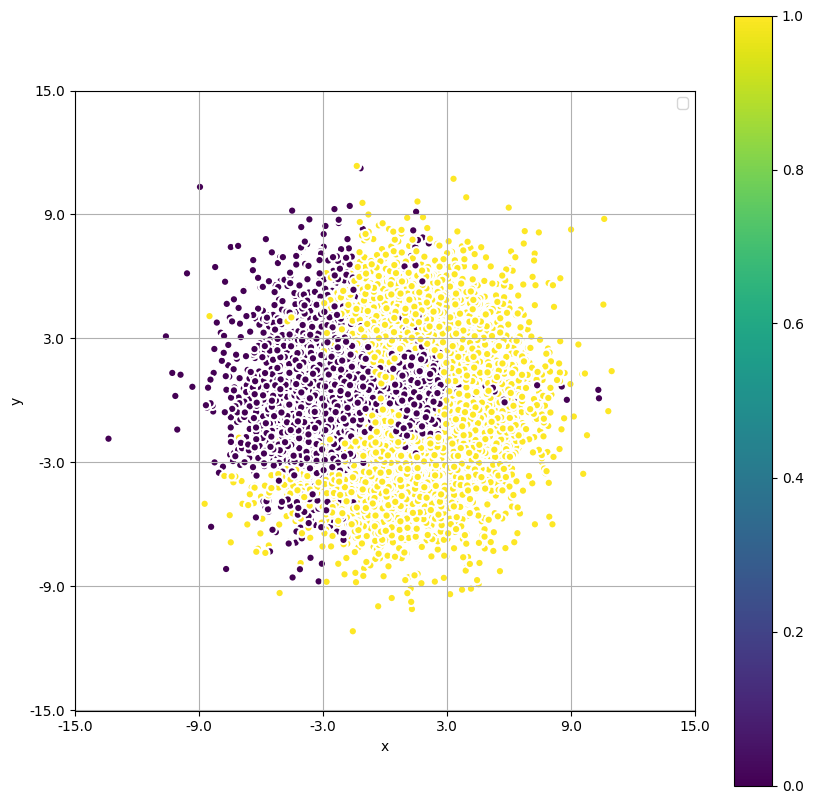

RandomForestClassifier:


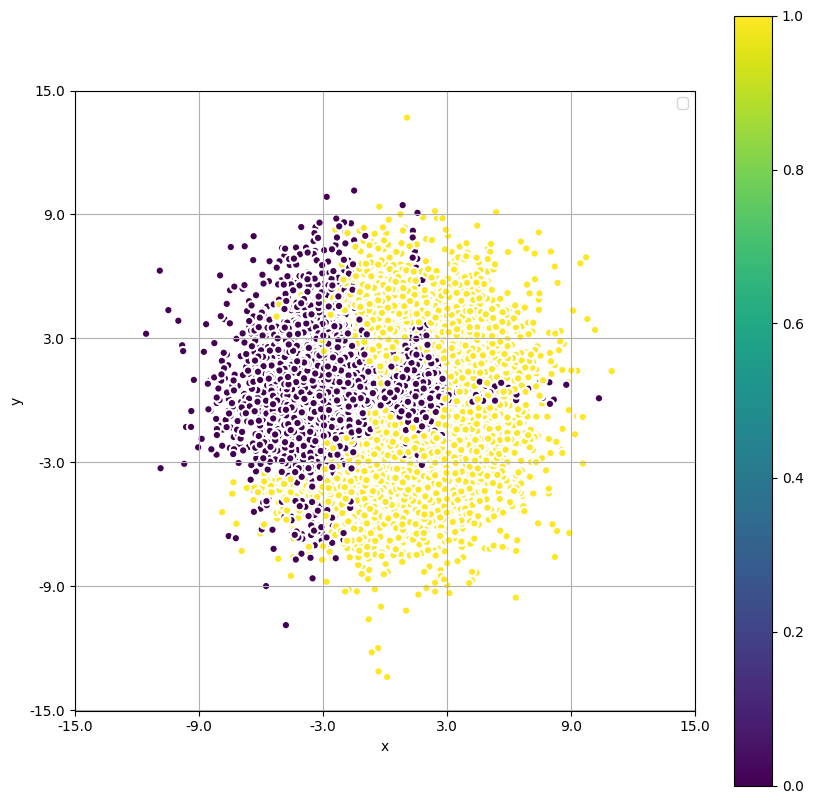

LinearRegression:


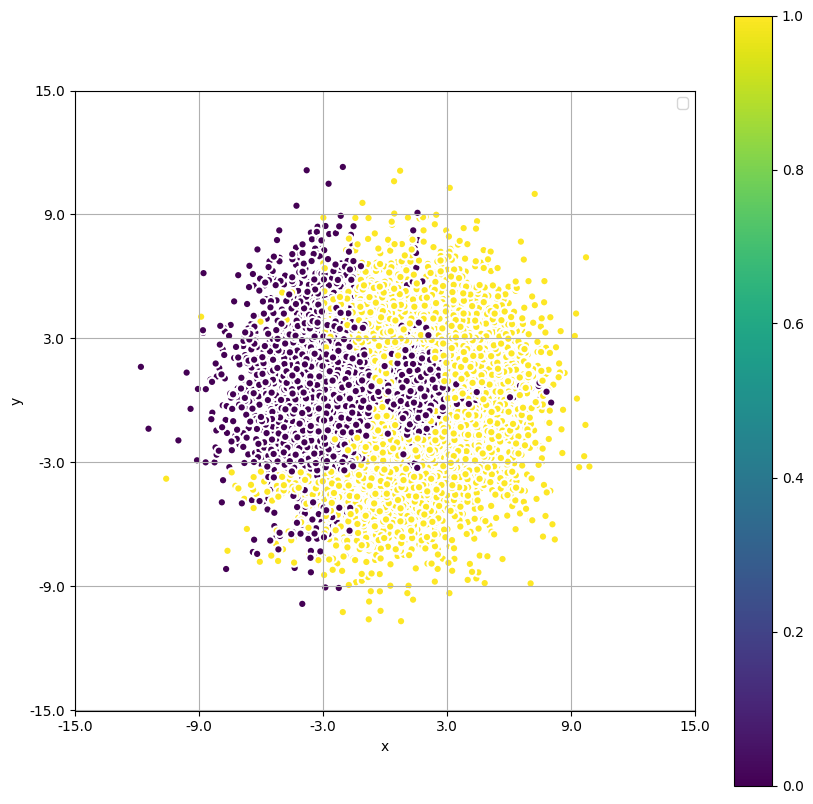

In [19]:
for base_model, name in zip(models.keys(), models_names):
    print(f'{name}:')
    model = Boosting(base_model_class=base_model, base_model_params=models[base_model])
    plot_predicts(model, X_synthetic, y_synthetic)

**Вопросы:**

1) Какая из моделей имеет оптимальное качество? С чем это связано?

2) Какая из моделей сильнее переобучается? Есть ли преимущества от использования ранней остановки и обрезания бустинга до лучшей модели?

3) Работает ли бустинг над линейными регрессиями лучше, чем одна логистическая регрессия? Как объяснить этот результат?

4) Визуализируйте предсказания моделей только на синтетическом датасете (для этого можете воспользоваться вспомогательной функцией plot_predicts). Чем отличаются картинки, которые получаются у разных алгоритмов? Сделайте выводы.

**Ваш ответ здесь**

### **Задание 3. (0.8 балла) Сравнение с бустингами**

- Сравните на реальных данных данных любую из трёх популярных имплементаций градиентного бустинга (xgboost, lightgbm, catboost) с вашей реализацией.
- Укажите, получилось ли у вас победить библиотечные реализации на тестовых данных?

**Примечание:**

Подберите основные гиперпараметры (число деревьев, длина шага, глубина дерева/число листьев) для обоих методов.


In [20]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

In [21]:
X_train = df_train.drop('y', axis=1).select_dtypes(['int64', 'float64']).values
X_test = df_test.drop('y', axis=1).select_dtypes(['int64', 'float64']).values

y_train = (df_train.y == 1).astype('int')
y_test = (df_test.y == 1).astype('int')

In [22]:
param_grid = {'n_estimators': np.arange(10, 101, 10),
              'learning_rate':[0.01, 0.1, 0.5, 1],
              'base_model_params': [{'max_depth': 5, 'max_features': 0.1}, {'max_depth': 15, 'max_features': 0.1}]
              }
gs = GridSearchCV(XGBClassifier(), param_grid=param_grid, cv=5)
gs.fit(X_train, y_train)
best_xgboost = gs.best_estimator_

In [29]:
gs = GridSearchCV(Boosting(), param_grid=param_grid, cv=5)
gs.fit(X_train, y_train)
best_boosting = gs.best_estimator_

ValueError: 
All the 400 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
80 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\bodyk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\bodyk\AppData\Local\Temp\ipykernel_28588\1619018886.py", line 116, in fit
    model = self._fit_new_model(X, residuals, n_model)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\bodyk\AppData\Local\Temp\ipykernel_28588\1619018886.py", line 61, in _fit_new_model
    X_sample, y_sample = X[sample_indices], y[sample_indices]
                                            ~^^^^^^^^^^^^^^^^
  File "C:\Users\bodyk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pandas\core\series.py", line 1153, in __getitem__
    return self._get_with(key)
           ^^^^^^^^^^^^^^^^^^^
  File "C:\Users\bodyk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pandas\core\series.py", line 1180, in _get_with
    return self.loc[key]
           ~~~~~~~~^^^^^
  File "C:\Users\bodyk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pandas\core\indexing.py", line 1191, in __getitem__
    return self._getitem_axis(maybe_callable, axis=axis)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\bodyk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pandas\core\indexing.py", line 1420, in _getitem_axis
    return self._getitem_iterable(key, axis=axis)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\bodyk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pandas\core\indexing.py", line 1360, in _getitem_iterable
    keyarr, indexer = self._get_listlike_indexer(key, axis)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\bodyk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pandas\core\indexing.py", line 1558, in _get_listlike_indexer
    keyarr, indexer = ax._get_indexer_strict(key, axis_name)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\bodyk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pandas\core\indexes\base.py", line 6200, in _get_indexer_strict
    self._raise_if_missing(keyarr, indexer, axis_name)
  File "C:\Users\bodyk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pandas\core\indexes\base.py", line 6252, in _raise_if_missing
    raise KeyError(f"{not_found} not in index")
KeyError: '[2127, 410, 292, 2208, 2083, 3038, 3643, 675, 2586, 2473, 3465, 2707, 3286, 1785, 4387, 5255, 4880, 1729, 4401, 5599, 4067, 2487, 1922, 4604, 5725, 5837, 1934, 4747, 2603, 5168, 2762, 3784, 4553, 3057, 2997, 4765, 2133, 3181, 3936, 3707, 5768, 982, 3139, 5167, 1530, 4264, 3992, 1189, 2118, 3948, 3704, 4028, 3914, 5669, 473, 4052, 4471, 2533, 2332, 4692, 4352, 93, 4001, 4298, 4323, 274, 2995, 5097, 2903, 68, 455, 3666, 5405, 2589, 1565, 231, 2167, 761, 883, 3794, 1590, 881, 1962, 3570, 432, 1578, 88, 5033, 1512, 2523, 1893, 2513, 5816, 3662, 5253, 1129, 4793, 1703, 1263, 293, 856, 4139, 1156, 505, 549, 4934, 4317, 222, 1287, 4830, 1197, 1244, 3260, 5858, 3257, 4475, 4942, 2543, 3133, 3653, 1041, 1858, 4486, 3185, 5397, 2495, 3165, 763, 2879, 3125, 1706, 3396, 211, 3721, 1436, 1055, 1042, 1385, 2302, 2882, 2145, 322, 181, 5151, 2918, 2372, 4463, 5875, 3962, 3050, 5763, 733, 573, 1541, 1869, 4374, 4842, 2718, 385, 110, 1046, 4731, 2663, 4112, 5117, 5820, 927, 321, 3035, 1456, 5839, 599, 5292, 4541, 1680, 1469, 5446, 3787, 1864, 1222, 1071, 2215, 3122, 3317, 2271, 2922, 4816, 5527, 4098, 4466, 4127, 4418, 3689, 228, 4355, 2846, 360, 2770, 1328, 45, 766, 1079, 5407, 5914, 712, 5555, 672, 3686, 1426, 3939, 1618, 3316, 397, 378, 3269, 1509, 30, 847, 696, 1915, 782, 1662, 2715, 2577, 2833, 2036, 2246, 4415, 4896, 5269, 3577, 668, 1563, 1254, 2864, 3428, 1586, 5096, 1146, 4952, 2348, 5528, 1880, 5427, 2963, 5362, 4505, 1374, 1634, 3534, 642, 3256, 1472, 1545, 1335, 1181, 1978, 3006, 637, 5264, 2464, 4763, 5501, 5138, 2515, 1022, 214, 1606, 2002, 3946, 437, 2549, 756, 4751, 4527, 198, 81, 4922, 4110, 5318, 26, 5558, 5375, 4861, 2992, 2122, 474, 5639, 2771, 4169, 4560, 2855, 932, 1219, 625, 5014, 5566, 4125, 3733, 2647, 940, 3573, 4890, 5807, 3082, 1142, 1417, 5190, 2906, 5452, 2881, 3349, 4092, 4503, 106, 5899, 518, 3885, 5722, 724, 5377, 2299, 4749, 1820, 3019, 2214, 2152, 3166, 5309, 3582, 3857, 4651, 84, 4162, 3014, 2888, 5246, 169, 221, 2221, 303, 2313, 5843, 4180, 3746, 3114, 4194, 1894, 4802, 267, 1918, 3819, 5712, 4189, 70, 4908, 5882, 5214, 509, 2291, 5764, 5262, 2453, 3487, 5720, 2213, 4898, 1513, 801, 1168, 1623, 2029, 4704, 4633, 4159, 5436, 87, 4012, 730, 196, 5593, 4827, 3855, 5836, 3169, 3838, 2818, 5918, 5612, 3589, 5454, 898, 2089, 415, 5173, 5026, 3761, 5830, 5794, 858, 4081, 5270, 2664, 5048, 564, 2521, 3079, 1786, 3898, 2510, 3434, 1699, 5867, 2883, 2673, 2239, 1511, 3601, 1928, 1747, 76, 838, 5819, 3003, 3280, 3889, 5140, 58, 5687, 5325, 1966, 3715, 5027, 2638, 5696, 5826, 5041, 3328, 2287, 4038, 5589, 2777, 866, 543, 3375, 1405, 4787, 2354, 2154, 3639, 4609, 5663, 1722, 2886, 3463, 862, 2860, 239, 4404, 4029, 50, 4586, 4753, 3891, 2887, 1160, 3826, 5057, 1654, 4715, 2726, 5071, 3614, 1420, 5497, 3332, 4156, 4140, 5058, 1111, 5532, 1407, 3509, 3833, 4925, 4907, 5324, 3820, 1128, 1496, 5145, 4247, 1352, 3433, 4832, 5547, 4838, 4824, 3149, 3995, 1536, 5549, 1732, 2858, 3836, 3172, 3422, 1297, 2574, 4013, 5106, 1233, 5538, 3298, 3410, 3143, 527, 1375, 1670, 2602, 1957, 2716, 665, 5284, 1658, 1615, 1210, 833, 2588, 510, 4723, 5391, 5825, 831, 5576, 2646, 1807, 4060, 2310, 5531, 1108, 1561, 1366, 4659, 4607, 4371, 1383, 3254, 5285, 4894, 1406, 1292, 872, 353, 3011, 1569, 4042, 5681, 1559, 4102, 5100, 3299, 1427, 4048, 3443, 19, 3728, 1113, 2228, 3424, 3480, 4814, 100, 1087, 47, 1434, 1370, 835, 2458, 4619, 4453, 1744, 1320, 5653, 5520, 1614, 967, 1078, 3592, 503, 1740, 185, 178, 5221, 4639, 1166, 682, 3184, 3077, 1714, 2436, 1983, 1780, 1688, 1803, 3555, 4368, 5386, 1314, 2933, 3574, 5898, 2945, 468, 4303, 3677, 4482, 5022, 3078, 4003, 1883, 429, 5642, 1223, 1047, 2312, 2826, 1192, 4076, 4656, 1554, 1221, 5131, 1544, 3037, 411, 1174, 3467, 1277, 5331, 4215, 4046, 3950, 3309, 229, 4974, 1295, 5711, 5551, 3964, 812] not in index'

--------------------------------------------------------------------------------
80 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\bodyk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\bodyk\AppData\Local\Temp\ipykernel_28588\1619018886.py", line 116, in fit
    model = self._fit_new_model(X, residuals, n_model)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\bodyk\AppData\Local\Temp\ipykernel_28588\1619018886.py", line 61, in _fit_new_model
    X_sample, y_sample = X[sample_indices], y[sample_indices]
                                            ~^^^^^^^^^^^^^^^^
  File "C:\Users\bodyk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pandas\core\series.py", line 1153, in __getitem__
    return self._get_with(key)
           ^^^^^^^^^^^^^^^^^^^
  File "C:\Users\bodyk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pandas\core\series.py", line 1180, in _get_with
    return self.loc[key]
           ~~~~~~~~^^^^^
  File "C:\Users\bodyk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pandas\core\indexing.py", line 1191, in __getitem__
    return self._getitem_axis(maybe_callable, axis=axis)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\bodyk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pandas\core\indexing.py", line 1420, in _getitem_axis
    return self._getitem_iterable(key, axis=axis)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\bodyk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pandas\core\indexing.py", line 1360, in _getitem_iterable
    keyarr, indexer = self._get_listlike_indexer(key, axis)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\bodyk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pandas\core\indexing.py", line 1558, in _get_listlike_indexer
    keyarr, indexer = ax._get_indexer_strict(key, axis_name)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\bodyk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pandas\core\indexes\base.py", line 6200, in _get_indexer_strict
    self._raise_if_missing(keyarr, indexer, axis_name)
  File "C:\Users\bodyk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pandas\core\indexes\base.py", line 6252, in _raise_if_missing
    raise KeyError(f"{not_found} not in index")
KeyError: '[2127, 292, 2083, 3038, 3643, 3504, 675, 1204, 2586, 4280, 297, 3465, 807, 2707, 3286, 1785, 4387, 5255, 1337, 4401, 4689, 4067, 3235, 1922, 551, 5098, 1217, 1268, 4604, 2470, 808, 5837, 4836, 1934, 5168, 4553, 1371, 62, 4765, 2133, 3936, 3193, 3707, 3159, 5768, 584, 3139, 3501, 5167, 2229, 3992, 4074, 3704, 1200, 1225, 4028, 3914, 5669, 4914, 2509, 4471, 2533, 1806, 4352, 1961, 93, 1270, 837, 4298, 274, 1498, 5097, 2903, 455, 5405, 1186, 5873, 2167, 761, 883, 44, 3794, 1962, 3570, 5339, 4204, 2055, 4296, 3626, 192, 88, 5033, 1512, 3092, 5621, 2523, 2513, 507, 3662, 5253, 2440, 1263, 3265, 856, 4139, 1156, 222, 861, 4626, 1287, 4830, 1197, 5858, 1384, 4942, 903, 2543, 3133, 4080, 5300, 3653, 1795, 5397, 3165, 981, 763, 679, 1911, 211, 1055, 443, 1042, 1482, 2302, 848, 240, 2330, 2145, 5151, 4463, 4877, 5875, 3962, 3050, 5763, 733, 4588, 4842, 2718, 555, 5614, 385, 975, 5780, 1046, 3734, 2663, 5117, 5820, 927, 321, 3035, 607, 1456, 5839, 5292, 4541, 3787, 1864, 1222, 1071, 2215, 489, 3122, 3317, 5267, 5076, 15, 958, 1736, 4816, 4328, 2934, 5527, 4098, 834, 4466, 4127, 3882, 4418, 1879, 3689, 650, 2846, 360, 2770, 3214, 2809, 1328, 766, 5407, 195, 5914, 712, 2248, 3686, 1426, 3939, 1618, 4883, 3316, 3479, 1509, 30, 2912, 1915, 782, 1662, 4550, 2036, 2505, 120, 4415, 2842, 925, 4372, 4863, 1114, 3577, 668, 2902, 5317, 1254, 2864, 3428, 907, 5349, 5096, 4952, 2348, 4161, 3360, 1860, 5528, 2789, 1397, 1477, 2250, 5272, 1880, 2963, 1344, 5362, 1374, 3278, 183, 109, 4707, 1472, 3268, 3409, 1978, 3006, 637, 5264, 2464, 5003, 4763, 1942, 690, 4383, 5138, 2515, 1022, 1606, 3770, 2002, 3946, 4751, 4246, 2017, 81, 143, 5318, 5558, 5375, 4861, 4075, 2992, 2122, 474, 5639, 2771, 553, 932, 1219, 625, 3805, 5014, 5566, 4125, 3733, 2596, 203, 940, 3293, 3573, 4890, 1032, 5787, 3539, 1142, 4391, 1417, 5190, 3956, 2202, 2977, 2906, 3164, 615, 2881, 2457, 3982, 106, 5899, 5869, 518, 724, 5377, 2299, 5316, 3019, 2214, 498, 2152, 5309, 2877, 3582, 3857, 5828, 2888, 387, 1683, 169, 221, 2221, 5366, 3746, 3114, 4194, 5128, 602, 4802, 267, 4460, 1918, 3819, 335, 3334, 4189, 113, 4434, 4965, 4034, 5011, 809, 5882, 509, 3605, 320, 5262, 4290, 2453, 3487, 4898, 731, 577, 1513, 1003, 3012, 5120, 1623, 5296, 3571, 1485, 2029, 4633, 5436, 2929, 844, 5562, 4641, 753, 87, 730, 5593, 4224, 4827, 5836, 3838, 3612, 5612, 783, 5821, 1379, 3589, 5454, 978, 3682, 2089, 3934, 4561, 3761, 5830, 5794, 4210, 5601, 944, 4081, 5270, 564, 3434, 4270, 1699, 3362, 336, 2883, 2673, 2239, 3502, 3601, 1928, 462, 4872, 1340, 1747, 1468, 76, 5819, 1294, 3003, 5786, 5371, 5862, 3715, 5027, 2638, 2629, 5826, 5229, 4766, 3231, 3513, 4252, 5646, 2287, 4038, 4198, 5589, 3183, 2463, 3520, 186, 2777, 866, 543, 1073, 5849, 2354, 3639, 1505, 4609, 5663, 4663, 2886, 862, 4687, 239, 4404, 5597, 50, 4586, 4937, 4753, 3891, 5496, 2726, 2775, 2387, 5071, 5020, 5212, 3614, 5497, 5006, 1423, 1354, 897, 4156, 4140, 5058, 1111, 5532, 3509, 3833, 1833, 4925, 2298, 4907, 5324, 1496, 5904, 3433, 5321, 5547, 4838, 4824, 3966, 2690, 3995, 5736, 5549, 1732, 2858, 5336, 3836, 1297, 2574, 1233, 5538, 3410, 5931, 3226, 820, 3258, 1670, 2540, 2602, 1957, 2716, 5284, 1615, 1210, 833, 272, 1973, 510, 4723, 494, 5903, 5825, 831, 3785, 4567, 5587, 1807, 4060, 1551, 2310, 5531, 1561, 5444, 1086, 4607, 4771, 2892, 3393, 4056, 5798, 1383, 3254, 5285, 1406, 872, 353, 3011, 2571, 1569, 2053, 1559, 977, 4102, 1982, 3779, 3299, 3443, 4288, 3358, 4657, 5927, 2746, 19, 3728, 2565, 3780, 2732, 2228, 3424, 5491, 4814, 1087, 776, 47, 636, 732, 75, 2458, 4619, 4453, 3058, 5653, 5520, 1614, 967, 1078, 503, 3382, 1740, 4638, 185, 5682, 4490, 3357, 5571, 682, 3077, 2436, 1666, 1780, 1688, 1803, 2117, 2338, 4695, 2045, 4306, 4368, 2925, 5386, 1314, 1808, 3574, 2945, 3049, 4482, 5022, 2076, 1874, 429, 5642, 2826, 4076, 2689, 1544, 2323, 3037, 411, 3467, 1277, 4983, 4046, 2345, 3950, 3309, 2778, 229, 4974, 1295, 4483, 757, 3964, 4108] not in index'

--------------------------------------------------------------------------------
80 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\bodyk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\bodyk\AppData\Local\Temp\ipykernel_28588\1619018886.py", line 116, in fit
    model = self._fit_new_model(X, residuals, n_model)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\bodyk\AppData\Local\Temp\ipykernel_28588\1619018886.py", line 61, in _fit_new_model
    X_sample, y_sample = X[sample_indices], y[sample_indices]
                                            ~^^^^^^^^^^^^^^^^
  File "C:\Users\bodyk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pandas\core\series.py", line 1153, in __getitem__
    return self._get_with(key)
           ^^^^^^^^^^^^^^^^^^^
  File "C:\Users\bodyk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pandas\core\series.py", line 1180, in _get_with
    return self.loc[key]
           ~~~~~~~~^^^^^
  File "C:\Users\bodyk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pandas\core\indexing.py", line 1191, in __getitem__
    return self._getitem_axis(maybe_callable, axis=axis)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\bodyk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pandas\core\indexing.py", line 1420, in _getitem_axis
    return self._getitem_iterable(key, axis=axis)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\bodyk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pandas\core\indexing.py", line 1360, in _getitem_iterable
    keyarr, indexer = self._get_listlike_indexer(key, axis)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\bodyk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pandas\core\indexing.py", line 1558, in _get_listlike_indexer
    keyarr, indexer = ax._get_indexer_strict(key, axis_name)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\bodyk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pandas\core\indexes\base.py", line 6200, in _get_indexer_strict
    self._raise_if_missing(keyarr, indexer, axis_name)
  File "C:\Users\bodyk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pandas\core\indexes\base.py", line 6252, in _raise_if_missing
    raise KeyError(f"{not_found} not in index")
KeyError: '[2011, 2127, 3366, 292, 2083, 3038, 3643, 2490, 675, 2586, 1988, 2694, 3465, 2707, 3286, 1785, 4387, 5255, 2566, 4401, 4276, 1116, 4067, 1922, 4604, 5837, 1934, 5213, 5168, 4553, 4987, 4765, 2133, 2186, 3936, 2052, 3707, 2767, 5768, 3139, 5461, 5167, 5024, 1137, 5641, 1776, 5385, 4916, 3992, 3690, 2972, 3704, 4028, 3075, 3914, 5669, 3871, 1395, 159, 5141, 2819, 4471, 3491, 2533, 1967, 7, 4352, 3407, 93, 2780, 5906, 305, 4298, 1920, 3637, 274, 5077, 5220, 5097, 2903, 455, 5405, 985, 1391, 2167, 761, 4305, 5310, 883, 3794, 1962, 4743, 3570, 887, 4287, 88, 5033, 1512, 2523, 1819, 2513, 5099, 2763, 3662, 5253, 1325, 5916, 2873, 1263, 1847, 856, 4139, 1156, 222, 1287, 4830, 1197, 5858, 5804, 781, 4942, 2543, 3133, 1381, 3653, 1085, 1401, 5397, 3165, 763, 1159, 1813, 873, 2655, 1264, 211, 1055, 1042, 2302, 5176, 2145, 5151, 4463, 5875, 3962, 3050, 5763, 733, 4842, 3197, 4888, 2718, 385, 3929, 1046, 2663, 3189, 5117, 5820, 49, 927, 5670, 5219, 321, 3035, 1456, 5839, 5292, 3866, 4541, 3787, 1864, 1222, 1071, 2215, 3122, 3317, 5659, 4816, 5527, 4098, 4072, 194, 4466, 1271, 4127, 1519, 4418, 3689, 2721, 2846, 360, 2770, 4320, 2379, 1328, 382, 5328, 5494, 1821, 766, 5407, 5914, 1064, 712, 4690, 4653, 3686, 1426, 3939, 1618, 1510, 3316, 3219, 1509, 30, 5184, 3447, 5042, 1915, 782, 1091, 1662, 2036, 1890, 4415, 2591, 2660, 5185, 3577, 668, 1254, 2864, 3428, 5209, 5096, 4952, 155, 2348, 508, 1628, 2451, 5528, 2822, 1880, 2963, 5362, 1374, 5540, 3793, 1472, 4912, 1978, 3006, 637, 5264, 2464, 4763, 5138, 2515, 5834, 2434, 1022, 289, 3339, 1606, 2002, 3946, 4751, 1673, 343, 81, 3938, 5318, 5847, 5558, 5375, 4861, 2992, 2122, 474, 5639, 451, 2771, 2277, 932, 1219, 625, 5014, 5566, 5223, 4125, 3733, 940, 356, 3573, 4890, 1142, 1417, 5190, 2906, 3807, 2600, 2881, 106, 5899, 1070, 3711, 518, 3750, 724, 5377, 2299, 3019, 2214, 1492, 1134, 2152, 5309, 680, 3582, 3857, 909, 4652, 2652, 2888, 4711, 3878, 5242, 169, 221, 2086, 3671, 2221, 3746, 3114, 4194, 264, 4424, 4802, 267, 4664, 3832, 1918, 5832, 3819, 4189, 5882, 509, 5262, 2453, 3487, 4898, 3996, 1513, 1135, 1623, 4154, 5611, 2029, 4627, 3237, 1589, 4958, 4633, 5436, 87, 730, 5593, 4577, 2915, 4827, 5836, 2714, 3838, 5612, 3589, 2803, 2784, 5454, 2089, 442, 3336, 4778, 3761, 5830, 5794, 4081, 2429, 5270, 470, 564, 3434, 1699, 5462, 2998, 3917, 2883, 2673, 4160, 3554, 5194, 2239, 5874, 3601, 256, 1928, 1747, 76, 5819, 3954, 3003, 2788, 3215, 1779, 3645, 3715, 5027, 2638, 4939, 5925, 5826, 1846, 2287, 4038, 2007, 5589, 2777, 866, 543, 2354, 3545, 3639, 4609, 3323, 3285, 5663, 4557, 4449, 2886, 862, 3116, 239, 4404, 50, 3156, 4586, 4753, 3891, 2726, 1904, 3588, 5403, 5071, 5715, 3614, 1089, 5497, 5654, 4156, 3140, 4140, 5058, 1111, 5532, 3509, 5672, 3833, 4925, 4907, 4357, 5324, 1496, 2450, 771, 2924, 3433, 4591, 5547, 3211, 4838, 4824, 4364, 5853, 24, 2773, 3995, 3277, 4669, 5549, 25, 1732, 2858, 3836, 3276, 1297, 2587, 2574, 1233, 5538, 3410, 5583, 1670, 2602, 1957, 2716, 5284, 1615, 1210, 833, 3606, 1767, 3831, 510, 4723, 52, 2305, 5825, 831, 3311, 1807, 5335, 4060, 2310, 1141, 5531, 1561, 4607, 2459, 1383, 3254, 5285, 1406, 872, 353, 3011, 1569, 1559, 4102, 1517, 3299, 3443, 1522, 1849, 3431, 19, 3728, 739, 1629, 2228, 1185, 3424, 4814, 1087, 47, 386, 2723, 2458, 4619, 4453, 5653, 2414, 5520, 1614, 967, 1078, 1275, 4570, 5169, 503, 3904, 5498, 1740, 185, 3935, 660, 4340, 682, 3077, 2436, 4456, 1213, 1780, 1688, 1803, 3825, 4207, 4368, 5386, 1314, 2151, 3574, 1774, 5417, 2945, 4482, 5022, 5322, 3162, 1948, 4654, 1473, 3809, 4578, 429, 3321, 5642, 2826, 4076, 3435, 32, 3700, 85, 1544, 3563, 4666, 2194, 3037, 411, 3467, 1277, 4046, 3950, 3309, 229, 4974, 1295, 2211, 4855, 3964, 4728] not in index'

--------------------------------------------------------------------------------
80 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\bodyk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\bodyk\AppData\Local\Temp\ipykernel_28588\1619018886.py", line 116, in fit
    model = self._fit_new_model(X, residuals, n_model)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\bodyk\AppData\Local\Temp\ipykernel_28588\1619018886.py", line 61, in _fit_new_model
    X_sample, y_sample = X[sample_indices], y[sample_indices]
                                            ~^^^^^^^^^^^^^^^^
  File "C:\Users\bodyk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pandas\core\series.py", line 1153, in __getitem__
    return self._get_with(key)
           ^^^^^^^^^^^^^^^^^^^
  File "C:\Users\bodyk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pandas\core\series.py", line 1180, in _get_with
    return self.loc[key]
           ~~~~~~~~^^^^^
  File "C:\Users\bodyk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pandas\core\indexing.py", line 1191, in __getitem__
    return self._getitem_axis(maybe_callable, axis=axis)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\bodyk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pandas\core\indexing.py", line 1420, in _getitem_axis
    return self._getitem_iterable(key, axis=axis)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\bodyk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pandas\core\indexing.py", line 1360, in _getitem_iterable
    keyarr, indexer = self._get_listlike_indexer(key, axis)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\bodyk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pandas\core\indexing.py", line 1558, in _get_listlike_indexer
    keyarr, indexer = ax._get_indexer_strict(key, axis_name)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\bodyk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pandas\core\indexes\base.py", line 6200, in _get_indexer_strict
    self._raise_if_missing(keyarr, indexer, axis_name)
  File "C:\Users\bodyk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pandas\core\indexes\base.py", line 6252, in _raise_if_missing
    raise KeyError(f"{not_found} not in index")
KeyError: '[2359, 772, 2127, 1900, 292, 5901, 2083, 3038, 3643, 1179, 675, 2586, 162, 2725, 3465, 2707, 3286, 1785, 4387, 4181, 5255, 4401, 4783, 4067, 2863, 1922, 3302, 4604, 3331, 631, 5837, 1934, 5168, 4553, 3389, 619, 403, 4683, 4765, 405, 5542, 2133, 3936, 3707, 5768, 3139, 340, 5167, 148, 3992, 2743, 3704, 4028, 3914, 4082, 5669, 4471, 2533, 935, 4352, 1809, 93, 4298, 1613, 274, 5097, 2903, 455, 5405, 4145, 5543, 3453, 4327, 608, 2167, 761, 4445, 1766, 883, 3794, 962, 1962, 277, 3570, 2037, 88, 5033, 1512, 2856, 3461, 2523, 2513, 593, 2043, 3729, 3427, 3662, 5253, 902, 3897, 1263, 2381, 856, 2014, 4139, 4501, 3056, 1269, 1156, 2947, 222, 1993, 1287, 855, 4830, 1197, 5858, 3670, 4942, 2543, 3133, 2253, 3653, 552, 1198, 4583, 5397, 3165, 763, 3638, 211, 1055, 1042, 2302, 5656, 2145, 5151, 4463, 5875, 3962, 3050, 5763, 733, 370, 1043, 3986, 4842, 2718, 385, 3737, 16, 5495, 1046, 3287, 2663, 4991, 5117, 5820, 2979, 927, 321, 3035, 5110, 1456, 5839, 454, 5292, 4815, 2084, 3178, 4541, 845, 1637, 3787, 1864, 1222, 1071, 2215, 3122, 3317, 1953, 3633, 2823, 5383, 4816, 5890, 4811, 5527, 4098, 4466, 4127, 4702, 5166, 4418, 3689, 4285, 2428, 2846, 360, 2770, 3144, 1328, 3568, 1660, 766, 2279, 5407, 3356, 5914, 1368, 526, 712, 916, 3686, 1426, 3939, 1618, 3316, 5859, 3369, 3988, 1509, 1607, 30, 1915, 782, 3702, 1662, 105, 4713, 2036, 3022, 3713, 4415, 1100, 867, 4760, 3577, 668, 165, 697, 1254, 2864, 3428, 5096, 4952, 754, 2348, 1855, 2978, 4479, 5528, 1284, 3174, 1880, 2137, 2963, 5218, 5362, 986, 4768, 5280, 1374, 2637, 1132, 1472, 2659, 1978, 3006, 637, 5264, 2464, 3694, 4763, 5138, 2515, 1022, 313, 1606, 2002, 3946, 4219, 4751, 35, 1072, 3678, 5692, 2990, 81, 5318, 2289, 5558, 5375, 4861, 2992, 2122, 474, 5639, 2771, 2097, 3292, 3631, 932, 5066, 1219, 625, 5014, 5566, 2889, 4349, 2044, 2562, 4125, 3733, 940, 3573, 4890, 1142, 4419, 78, 1417, 5190, 2906, 3259, 4540, 2881, 3911, 4244, 106, 5899, 518, 724, 237, 5377, 2299, 3179, 3019, 2214, 2152, 5309, 541, 3582, 2494, 3857, 4153, 3610, 2888, 2581, 169, 221, 1326, 2221, 3746, 3114, 4194, 5243, 521, 5724, 5439, 4802, 1058, 267, 2355, 5805, 1918, 407, 3819, 5094, 4189, 780, 1977, 5882, 509, 5262, 2453, 3487, 2468, 2672, 4898, 1513, 4473, 1623, 3873, 4403, 2029, 1431, 1050, 4633, 546, 5436, 1980, 3466, 1246, 1823, 819, 87, 730, 3188, 5593, 3811, 4827, 5836, 4798, 3838, 1229, 5612, 4790, 3589, 5454, 2556, 2089, 448, 3273, 3761, 269, 5830, 5794, 236, 4081, 5270, 564, 1124, 4155, 1486, 5432, 3088, 3434, 1699, 5275, 3848, 2883, 2673, 3192, 1753, 2239, 3601, 1928, 1747, 76, 5819, 1735, 3003, 5524, 3423, 3715, 5027, 2638, 4399, 5826, 1960, 2287, 4038, 5589, 2777, 866, 543, 2354, 5678, 3639, 4609, 5663, 2886, 3566, 862, 2920, 239, 3957, 4404, 575, 50, 4586, 4753, 3891, 2520, 2726, 2639, 5922, 4182, 5071, 2230, 1133, 3614, 2547, 5497, 4156, 4281, 5347, 4140, 5058, 1111, 5532, 3509, 3833, 4925, 4907, 1440, 5324, 1496, 250, 1861, 3433, 3725, 4037, 5547, 4838, 4824, 5406, 3995, 2460, 3052, 1863, 900, 5549, 1732, 2085, 2858, 3836, 3888, 1297, 2574, 1233, 5538, 3410, 1171, 4839, 1670, 1347, 2936, 5178, 2602, 1957, 2716, 1577, 5284, 1615, 1210, 833, 129, 510, 4723, 3683, 5568, 2528, 1000, 3883, 5825, 1681, 831, 1807, 4060, 2310, 3665, 5531, 365, 1561, 3493, 4607, 1682, 2147, 3081, 1383, 3254, 5285, 1442, 1406, 2444, 872, 353, 3011, 707, 1569, 1559, 4443, 4102, 5776, 3299, 3443, 2946, 2956, 226, 5683, 19, 3728, 2228, 3424, 4814, 1087, 47, 749, 2458, 4619, 4453, 5653, 5520, 1614, 967, 1078, 2334, 2054, 503, 1740, 185, 4040, 2810, 583, 3229, 682, 3077, 2436, 1780, 5548, 1688, 1803, 3371, 5183, 4368, 5386, 3635, 1286, 1314, 3747, 3574, 1343, 3233, 3456, 2945, 4482, 5833, 5022, 1709, 1404, 1327, 4016, 429, 3623, 5642, 2826, 4076, 1544, 3553, 520, 3037, 411, 5561, 3467, 1277, 4400, 2382, 4046, 4444, 2643, 4833, 3950, 3309, 229, 4974, 1295, 4941, 3964] not in index'

--------------------------------------------------------------------------------
80 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\bodyk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\bodyk\AppData\Local\Temp\ipykernel_28588\1619018886.py", line 116, in fit
    model = self._fit_new_model(X, residuals, n_model)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\bodyk\AppData\Local\Temp\ipykernel_28588\1619018886.py", line 61, in _fit_new_model
    X_sample, y_sample = X[sample_indices], y[sample_indices]
                                            ~^^^^^^^^^^^^^^^^
  File "C:\Users\bodyk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pandas\core\series.py", line 1153, in __getitem__
    return self._get_with(key)
           ^^^^^^^^^^^^^^^^^^^
  File "C:\Users\bodyk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pandas\core\series.py", line 1180, in _get_with
    return self.loc[key]
           ~~~~~~~~^^^^^
  File "C:\Users\bodyk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pandas\core\indexing.py", line 1191, in __getitem__
    return self._getitem_axis(maybe_callable, axis=axis)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\bodyk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pandas\core\indexing.py", line 1420, in _getitem_axis
    return self._getitem_iterable(key, axis=axis)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\bodyk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pandas\core\indexing.py", line 1360, in _getitem_iterable
    keyarr, indexer = self._get_listlike_indexer(key, axis)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\bodyk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pandas\core\indexing.py", line 1558, in _get_listlike_indexer
    keyarr, indexer = ax._get_indexer_strict(key, axis_name)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\bodyk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pandas\core\indexes\base.py", line 6200, in _get_indexer_strict
    self._raise_if_missing(keyarr, indexer, axis_name)
  File "C:\Users\bodyk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pandas\core\indexes\base.py", line 6252, in _raise_if_missing
    raise KeyError(f"{not_found} not in index")
KeyError: '[5135, 2127, 292, 4784, 2083, 3038, 3643, 675, 2586, 3465, 3579, 2707, 3286, 1785, 4387, 5256, 4853, 4401, 5600, 4067, 1922, 4604, 5726, 1934, 2711, 4553, 3738, 4492, 5151, 4765, 2133, 3936, 3707, 4804, 3139, 2243, 3744, 5168, 1069, 5642, 5386, 2806, 569, 3992, 1685, 3704, 1312, 4014, 4028, 3914, 5142, 4471, 2533, 4352, 93, 2878, 5073, 4298, 274, 2903, 846, 455, 3850, 4976, 1792, 294, 804, 4278, 2167, 761, 3530, 5311, 883, 3794, 983, 1962, 2139, 3570, 5340, 793, 88, 5033, 417, 1512, 5622, 4964, 2523, 2513, 4566, 5817, 3662, 1733, 1435, 5917, 1931, 2950, 1263, 856, 4139, 1156, 1248, 645, 1355, 222, 1914, 1287, 3507, 4830, 4835, 1197, 4942, 2543, 3133, 5301, 3653, 2082, 4849, 4616, 827, 3165, 763, 4521, 211, 225, 853, 1055, 1042, 3741, 2302, 5177, 5657, 2145, 2551, 5152, 4463, 1333, 5876, 938, 2599, 4432, 4186, 3962, 3050, 733, 3020, 1262, 4842, 2718, 385, 5781, 1409, 2969, 1046, 2663, 5118, 956, 927, 321, 3035, 1456, 5293, 4946, 4227, 3581, 4541, 5579, 502, 3787, 1864, 1222, 1071, 2215, 3122, 3317, 1704, 1686, 826, 5384, 4816, 5528, 4098, 4466, 4212, 4127, 2693, 5167, 4418, 3689, 4820, 2846, 360, 2770, 1328, 766, 5408, 36, 5915, 712, 5706, 3686, 1426, 3939, 1618, 3316, 4499, 3763, 74, 1509, 5233, 4177, 30, 4388, 2050, 3863, 1915, 782, 3417, 1007, 2745, 1662, 1843, 4491, 2036, 3141, 4415, 2461, 5182, 5270, 4555, 5148, 3556, 262, 3577, 668, 2027, 5318, 823, 1254, 2864, 3428, 5210, 5290, 698, 5097, 4952, 2348, 1341, 924, 1214, 2560, 1880, 2963, 545, 5363, 2797, 1374, 3186, 4164, 5541, 1472, 2376, 3072, 1978, 936, 3006, 4869, 637, 2667, 1306, 2464, 2624, 4763, 5450, 5139, 2515, 5835, 1022, 920, 1606, 2002, 3946, 4111, 4751, 2744, 2824, 81, 5319, 4861, 2992, 2122, 474, 504, 5640, 1021, 2771, 2790, 932, 5067, 1219, 625, 5014, 5567, 2129, 3894, 4681, 4125, 3733, 2421, 940, 3573, 4890, 3974, 5839, 1142, 2454, 1417, 5191, 2906, 362, 4070, 404, 1625, 4858, 2881, 2891, 106, 2443, 5870, 518, 724, 2299, 3019, 2214, 3108, 1804, 2152, 2106, 54, 3582, 3472, 2558, 77, 3857, 4876, 2888, 3376, 169, 221, 2221, 3746, 3114, 2030, 4194, 4910, 5244, 2489, 5440, 4802, 4282, 267, 1918, 3819, 5713, 4189, 2012, 1734, 5215, 509, 5765, 2396, 4142, 2453, 3487, 3644, 4898, 1513, 1757, 1591, 1623, 2736, 5612, 2029, 4300, 825, 4225, 4234, 4633, 4124, 2872, 1585, 770, 87, 1690, 730, 2514, 3157, 4827, 5837, 153, 4465, 3838, 5919, 4737, 5822, 3589, 2089, 5700, 3761, 3310, 571, 5051, 3329, 4081, 5049, 564, 1524, 3434, 1716, 1699, 5276, 5463, 1540, 4178, 5868, 2883, 2673, 2239, 3476, 5875, 1308, 3601, 1928, 1747, 76, 5820, 4494, 726, 3003, 1707, 5468, 3715, 5027, 2638, 5081, 954, 2287, 4038, 338, 2604, 4971, 2777, 866, 543, 4831, 2354, 3639, 4609, 4297, 5664, 922, 4197, 2886, 3913, 3719, 862, 4662, 239, 4404, 50, 4586, 4753, 3891, 5497, 5058, 2726, 4321, 5299, 2033, 5625, 3614, 1256, 2433, 4156, 5292, 4140, 1111, 5533, 3509, 3833, 4925, 4907, 1604, 4, 1496, 3433, 1639, 4363, 4838, 4203, 4824, 5854, 5407, 4729, 3995, 2961, 1732, 2858, 3836, 1297, 2574, 1233, 2116, 3444, 3410, 3267, 1670, 5893, 2602, 2866, 4688, 1957, 4218, 2716, 2026, 5285, 4788, 1615, 1210, 833, 3925, 510, 4723, 395, 5569, 3451, 5392, 5826, 4206, 1622, 831, 4675, 5588, 1807, 3415, 4060, 2310, 5532, 1561, 4079, 5445, 987, 4607, 2219, 1383, 3254, 1406, 872, 353, 3011, 4530, 1569, 4926, 1559, 301, 4102, 3385, 3299, 3443, 1646, 3636, 2708, 19, 3728, 302, 2228, 3424, 4814, 1087, 47, 94, 2458, 4619, 1291, 4453, 1614, 967, 1078, 2105, 503, 1740, 3300, 185, 5156, 682, 3077, 2436, 1780, 5549, 1688, 1803, 3695, 224, 4368, 5387, 1816, 1314, 3574, 2143, 5899, 5914, 1218, 5418, 2945, 1854, 4482, 5022, 2612, 953, 2782, 429, 1028, 2826, 4076, 3900, 1544, 806, 5619, 3037, 411, 3147, 244, 3462, 3467, 4719, 1277, 4046, 4543, 3950, 3309, 481, 229, 4974, 1295, 3964, 235, 4242, 37] not in index'


**Ваш ответ здесь**

###**Задание 4. (1 балл) Капля теории**

Теоретически, мы могли бы построить бэггинг на логистических регрессиях. Оцените целесообразность такого подхода. В ответе укажите:

- Идею бэггинга и его свойства;
- Характеристики модели логистической регресии;
- Сопоставление и вывод.


## **Часть 1: Разделение изображения на семантические компоненты**

**Количество баллов:** 3

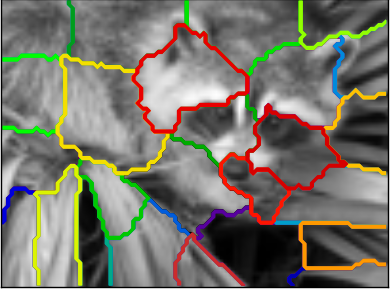

Алгоритмы кластеризации могут применяться в самых разных задачах. Например, в анализе изображений есть задача разделения изображения на семантические компоненты, которую можно решать в том числе с помощью алгоритмов кластеризации.

Проверим их на ```duck.jpg``` и ```owls.jpg```

### **Задание 5 (0.2 балла)**

Откройте изображения, после чего визуализируйте их с помощью ```plt.imshow()```

In [247]:
from PIL import Image
import cv2 as cv

In [243]:
ducks = cv.imread('duck.jpg')[...,::-1]
owls = cv.imread('owls.jpg')[...,::-1]

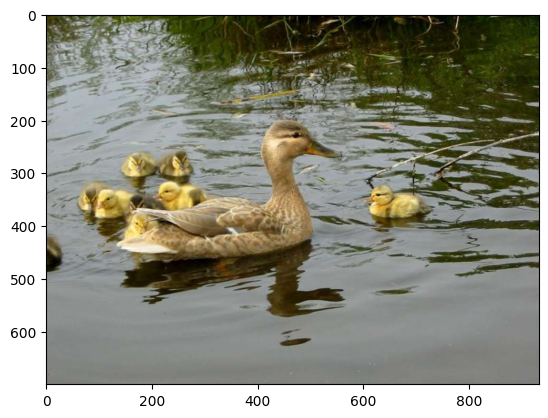

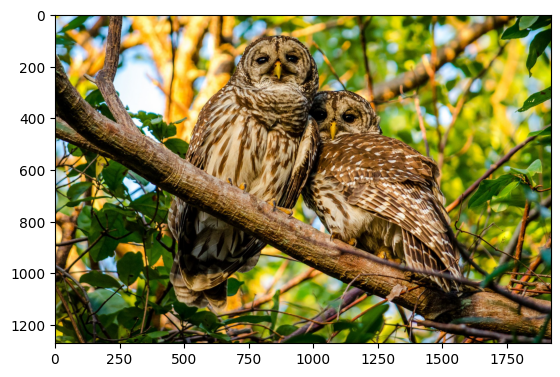

In [246]:
plt.imshow(ducks)
plt.show()
plt.imshow(owls)
plt.show()

### **Задание 6 (0.8 балла)**

Для каждого изображения, используя кластеризацию ```KMeans```, выделите компоненты, охарактеризовав каждый пиксель следующим образом: $$\psi_i = [\lambda x_i, \lambda y_i, r_i, g_i, b_i]$$
 где
- $x_i$ и $y_i$ — координаты пикселя,
- $r_i, g_i, b_i$ — его цвет,
- $\lambda$ — параметр, выражающий важность пространственной связности перед цветовой похожестью.

- Примените полученную функцию, взяв следующие $\lambda$: 0.3 и 1.5 для ```duck.jpg``` и ```owls.jpg``` (или другие, но тогда с вас красивые результаты :))
- Проанализируйте результат

**Примечание:**
Число кластеров подберите разумным образом на свой вкус (в качестве нулевого приближения можно взять 3)

In [256]:
from sklearn.cluster import KMeans

In [257]:
def find_components(image, lmbd, n_clusters):
    image_array = np.array(image)

    height, width, _ = image_array.shape

    features = []
    for y in range(height):
        for x in range(width):
            r, g, b = image_array[y, x]
            psi = [lmbd * x, lmbd * y, r, g, b]
            features.append(psi)

    features = np.array(features)

    # Применяем KMeans
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(features)

    labels = kmeans.labels_

    clustered_image = np.zeros_like(image_array)
    for i, label in enumerate(labels):
        y = i // width
        x = i % width
        clustered_image[y, x] = kmeans.cluster_centers_[label][2:].astype(int)

    return clustered_image

**Ваш ответ здесь**

### **Задание 7 (0.8 балла)**

Попробуйте выделить сегменты при помощи [спектральной кластеризации](http://scikit-learn.org/stable/modules/clustering.html#spectral-clustering). Обратите внимание на [пример в sklearn](http://scikit-learn.org/0.16/auto_examples/cluster/plot_lena_segmentation.html).


**Примечание:**

Для ускорения работы алгоритма рекомендуется привести изображение к серому цвету. При необходимости можно сжать изображения в 2 раза.

**Подсказка:**```skimage``` с его ```color``` и ```transform``` в этом помогут :)

Или же воспользуйтесь аналогичными средствами ```PIL``` или ```cv2```

In [258]:
from sklearn.cluster import SpectralClustering

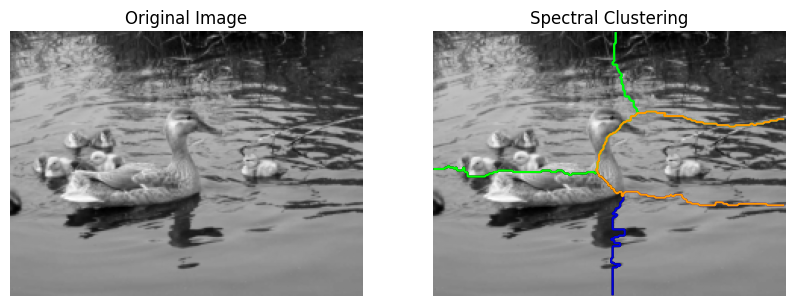

KeyboardInterrupt: 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction import image
from sklearn.cluster import spectral_clustering
from skimage import color, io, transform

# Загрузка изображения
def load_image(image_path):
    img = io.imread(image_path)
    img = color.rgb2gray(img)
    return img

# Уменьшение размера изображения
def resize_image(img, scale_factor=0.25):
    return transform.rescale(img, scale_factor, mode='reflect')

# Спектральная кластеризация
def apply_spectral_clustering(img, n_clusters=3, beta=5):
    # Преобразуем изображение в граф
    graph = image.img_to_graph(img)

    # Применяем экспоненциальную функцию к градиентам
    eps = 1e-6
    graph.data = np.exp(-beta * graph.data / img.std()) + eps

    # Применяем спектральную кластеризацию
    labels = spectral_clustering(graph, n_clusters=n_clusters, assign_labels='kmeans', random_state=1)
    labels = labels.reshape(img.shape)

    return labels

# Визуализация результата
def plot_results(img, labels, n_clusters):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(img, cmap='gray')
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(img, cmap='gray')
    for l in range(n_clusters):
        plt.contour(labels == l, contours=1, colors=[plt.cm.nipy_spectral(l / float(n_clusters))])
    plt.title("Spectral Clustering")
    plt.axis('off')

    plt.show()

# Основная функция
def process_image(image_path, n_clusters=11, beta=5):
    # Загрузка и предобработка изображения
    img = load_image(image_path)
    img = resize_image(img, scale_factor=0.25)
    labels = apply_spectral_clustering(img, n_clusters=n_clusters, beta=beta)
    plot_results(img, labels, n_clusters)

# Пример использования
image_paths = ["duck.jpg", "owls.jpg"]
for image_path in image_paths:
    process_image(image_path, n_clusters=10, beta=5)

In [262]:
def load_image(image_path):
    img = io.imread(image_path)
    img = color.rgb2gray(img)
    return img

# Уменьшение размера изображения
def resize_image(img, scale_factor=0.25):
    return transform.rescale(img, scale_factor, mode='reflect')

def spectral_segmentation(img, n_clusters, beta, eps=1e-6):
    graph = image.img_to_graph(img)

    graph.data = np.exp(-beta * graph.data / img.std()) + eps

    labels = spectral_clustering(graph, n_clusters=n_clusters, assign_labels='kmeans', random_state=1)
    labels = labels.reshape(img.shape)

    return labels

def process_image(image_path, n_clusters, beta=5):
    img = load_image(image_path)
    img = resize_image(img, scale_factor=0.25)
    labels = apply_spectral_clustering(img, n_clusters=n_clusters, beta=beta)
    return labels

### **Задание 8 (0.2 балла)**
- Визуализируйте результаты сегментации (аналогично рисунку в начале задания 2) для обоих методов.
- Проанализируйте сравнение

In [ ]:
# Ваш код здесь

**Ваш ответ здесь**

### **Задание 9 (1 балл)**

- Найдите интересную картинку милого животного и примените алгоритмы и к ней. Поэкспериментируйте с параметрами алгоритмов и постарайтесь добиться оптимального результата. Картинку нужно будет загрузить вместе с работой.

- Сравните два подхода и сегментации, к которым они приводят. Для всех ли изображений в результате сегментации хорошо видны контуры объектов?

**Примечание:**

Слишком большие лучше не брать - считаться будет долго. Не забудьте визуализировать!


In [ ]:
# Ваш код здесь

**Ваш ответ здесь**

## **Бонус (1 балл)**

В качестве бонуса предлагаем вам построить алгоритм кластеризации типов движения на наборе Samsung Human Activity Recognition. Набор данных заранее предобработан и снова доступен вам по [ссылке](https://drive.google.com/file/d/16ISu7lMumt5rbticbOggHMRjwTGBETtO/view?usp=sharing).

### **Постановка задачи**
Данные поступают с акселерометров и гироскопов мобильных телефонов Samsung Galaxy S2. Вид активности человека с телефоном в кармане известен:
- 1 - ходьба,
- 2 - подъем вверх по лестнице,
- 3 - спуск по лестнице,
- 4 - сидение,
- 5 - стояние,
- 6 - лежание


Представим, что вид активности нам неизвестнен, и попробуем кластеризовать людей чисто на основе имеющихся признаков.

### **Задание 1 (0.05 балла)**
Прочитайте данные из файлов и объедните тестовую и обучающие выборки.

В файлах ```..._labels``` лежат настоящие классы. Их также объедините, но в отдельную переменную (например ```y```). Данный вектор для кластеризации нам не нужен, но мы будем смотреть по нему метрики.

In [ ]:
# Ваш код здесь
X =
y =

In [ ]:
# убедимся, что y содержит нужные нам классы
np.unique(y)

### **Задание 2 (0.05 балла)**

Так как мы будем пользоваться метрическими алгоритмами, отмасштабируйте выборку с помощью ```StandardScaler```.

In [ ]:
# Ваш код здесь
scaler =
X_scaled =

### **Задание 3 (0.15 балла)**

Данных много и размерность большая. Чтобы ускорить рещение задачи с точки зрения построения модели, мспользуем методы **понижения размерности**. В частности, мы будем использовать метод главных компонент. Если вы проходили степик, то знакомы с ним, если нет, то почитать про PCA вам нужно в [Конспекте](https://github.com/esokolov/ml-course-hse/blob/master/2020-fall/lecture-notes/lecture12-factorizations.pdf).

- Понизьте размерность с помощью `PCA`, оставляя столько компонент, сколько нужно для того, чтобы объяснить как минимум 90% дисперсии отмасштабированных данных. Вам пригодится [документация](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)

**Примечание:**
Для этого сумма массива pca.explained_variance_ratio_ должна быть больше 0.9.  ```random_state``` используйте из объявленной в самом начале переменной ```RANDOM_STATE``` (42).

In [ ]:
# Ваш код здесь
plt.scatter()

### **Задание 4. (0.15 балла)**

Разберёмся с `KMeans`, [doc](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)

- Сделайте кластеризацию данных методом `KMeans`, обучив модель на данных со сниженной за счет `PCA` размерностью. Нужно искать 6 кластеров (изначально у нас 6 классов). Засеките время обучения и время инференса.

**Параметры обучения:**

```n_clusters = 6``` (число уникальных меток целевого класса = 6)

```n_init = 100```

```random_state = RANDOM_STATE``` (для воспроизводимости результата, не забывайте указывать его и дальше!)

In [ ]:
# Ваш код здесь

### **Задание 6 (0.05 балла)**

- Визуализируйте данные в проекции на первые две главные компоненты.
- Раскрасьте точки в соответствии с полученными метками кластеров.

In [ ]:
# Ваш код здесь

### **Задание 7 (0.1 балла)**

- Выберите какие-то метрики (минимум две) из известных вам. Объясните свой выбор
- Выведите на экран значения метрик качества, сделайте вывод о них и используйте их далее.

In [ ]:
# Ваш код здесь

**Ваш ответ здесь.**

### **Задание 8 (0.15 баллов)**

Теперь попробуем сделать кластеризацию с помощью `AgglomerativeClustering`, [doc](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html)

- Засеките время обучения и время инференса. После кластеризации также:
  - Вновь визуализируйте данные с раскраской по полученным меткам
  - Выведите метрики. Засеките время обучения и время инференса. Сравните с ```KMeans```.

Ответьте на следующие вопросы:
* Стало ли лучше?
* Почему?

In [ ]:
# Ваш код здесь

**Ваш ответ здесь.**

### **Задание 9 (0.3 балла)**
Для самой успешной из полученных кластеризаций попробуйте дать интерпретацию кластеров. Опишите характеристики объектов, попавших в каждый кластер. Для этого можете ответить на следующие вопросы:

* Похожи ли объекты внутри каждого кластера на определенный тип активности человека?
* В каких кластерах смешано несколько типов активности? С чем, на ваш взгляд, это может быть связано?
* Качественная ли получилась кластеризация? На основании чего вы можете сделать такой вывод?

**Ваш ответ здесь.**

**Вы ещё здесь!** или **уже**?)

Спасибо за труд! Котобонус:

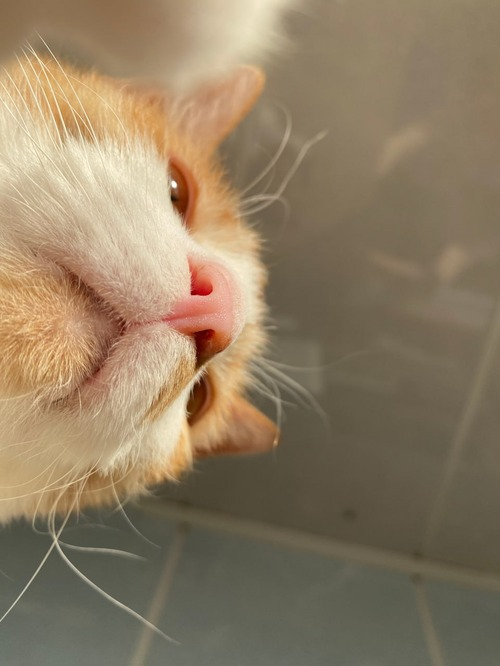